# [★★★★☆] Thin-walled Section For Frame Structures

In this example, we demonstrate how to create arbitrary sections and perform analysis with nonlinear torsion and warping enabled.

The relevant scripts can be [downloaded](thin-walled-section.zip).

To represent conventional, bending moment only sections numerically, only geometry information, such as location and area, is required. This allows the usage of predefined basic shapes, such as rectangles, circles. And complex sections can be built up by using those basic shapes. However, such an approach is not practical for sections involving torsion and warping, as some important sectional properties can only be obtained by analysing the section as a whole. Hence, a general approach that only focuses on section discretisation is used. The discretisation refers to the division of the section into a number of fibres/cells. Those fibres are the smallest units that are used in numerical integration. The users shall provide the corresponding sectional properties.

To obtain necessary sectional properties, a section analysis shall be performed. For arbitrary sections, often a general purpose FEA based method shall be used. [This](https://doi.org/10.1002/9780470172667) book provides a thorough discussion on relevant numerical methods.

The [`sectionproperties`](https://sectionproperties.readthedocs.io/en/latest/) library implements such a method. It can be used to prepare data to be used in `suanPan`.

## Theory

We first discuss what sectional properties are required and provide a theoretical background.

The [`Cell3DOS`](../../../Library/Section/SectionOS/Cell3DOS.md) section has the following signature.

```text
section Cell3DOS (1) (2) (3) (4) (5) (6) [7] [8]
# (1) int, unique section tag
# (2) double, area
# (3) double, sectional coordiante
# (4) double, py
# (5) double, pz
# (6) int, material tag
# [7] double, eccentricity/location along y axis, default: 0.0
# [8] double, eccentricity/location along z axis, default: 0.0
```

Apart from the location (coordinates/eccentricities) and area, it requires sectional coordinate (warping function) `(3)` and its derivatives `(4)` and `(5)`.

The warping function is the conventional one that can be expressed as a function of locations.

$$
\omega=\omega(y,z).
$$

The integration shall result in a net-zero warping.

$$
\int_A\omega(y,z)~\mathrm{d}A=0.
$$

Its derivatives along two axes are also required.

$$
\dfrac{\partial\omega}{\partial{}y},\qquad\dfrac{\partial\omega}{\partial{}z}.
$$

[Alemdar's thesis](http://hdl.handle.net/1853/22220), and some other derivatives, uses $$\gamma=2n\phi'$$ to approximate shear strain. This is only suitable for thin-walled open sections.
Here we use general formulation instead for complex, universal, arbitrary sections.
Interested readers can refer to, for example, [Pilkey's book](https://doi.org/10.1002/9780470172667), for more details.

Two shear strains can be expressed as follows.

$$
\gamma_{xy}=\phi'\left(\dfrac{\partial\omega}{\partial{}y}-z\right),\qquad
\gamma_{xz}=\phi'\left(\dfrac{\partial\omega}{\partial{}z}+y\right).
$$

## A Simple Example

We start with a simple circular example. Let's assume it is centred and has a diameter of $$10$$.

We use built-in functionality to create such a geometry and assign a mesh size of $$0.1$$.

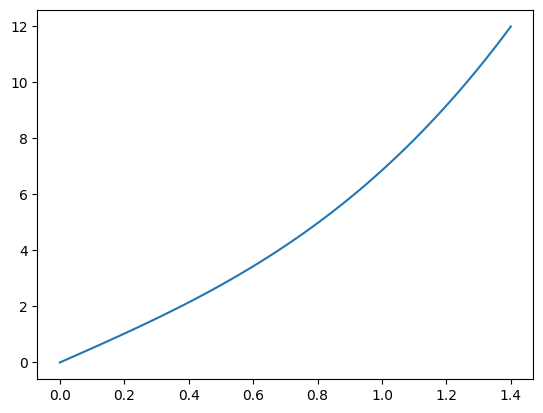

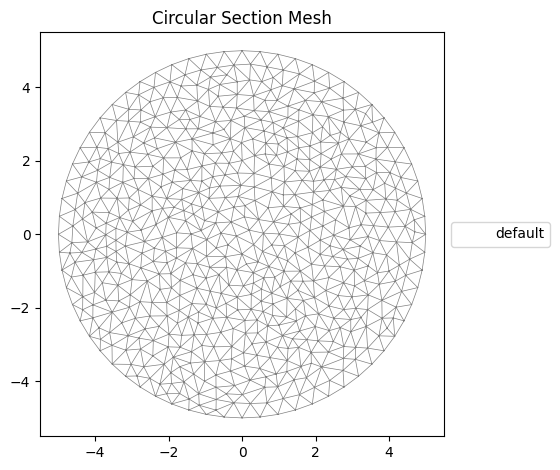

<Axes: title={'center': 'Circular Section Mesh'}>

In [25]:
import matplotlib.pyplot as plt
import sectionproperties.pre.library.primitive_sections as sections
from sectionproperties.analysis.section import Section

# approximate a circle by a polygon
geometry = sections.circular_section(d=10, n=64)
geometry.create_mesh(mesh_sizes=[0.1])
section = Section(geometry)
section.plot_mesh(title="Circular Section Mesh")

The mesh is generated internally using second-order triangular elements (CPS6 in ABAQUS notation).
One can check the details of the created elements.
The following shows the first element.

In [26]:
ele = section.elements[0]
print(ele)

el_id: 0
coords: [[-4.34131813 -4.06423264 -4.0599279  -4.20277539 -4.06208027 -4.20062302]
 [-2.05329056 -2.27511995 -1.92020289 -2.16420526 -2.09766142 -1.98674672]]
node_ids: [ 71  72  65 634 635 636]
material: Material(name='default', elastic_modulus=1, poissons_ratio=0, yield_strength=1, density=1, color='w')


### Area

The library has implemented basic utility functions to elements, such that basic properties for each element can be conveniently obtained.

In [27]:
print("(area, qx, qy, ixx, iyy, ixy, e, g, rho)")
print(ele.geometric_properties())

(area, qx, qy, ixx, iyy, ixy, e, g, rho)
(0.04964864399827342, -0.10341172739100991, -0.20629803759365845, 0.21565931750893194, 0.8574163726167644, 0.4296612130739319, 1, 0.5, 1)


Alternatively, the area can also be computed as the determinant of the Jacobian matrix of the isoparametric mapping.

### Locations

We assume the triangle element is small enough so that the centroid can represent the location of the element. The centroid can be obtained by averaging the coordinates of the first three nodes.

In [28]:
coords = ele.coords[:, :3]
centroid = coords.mean(axis=1)
print(centroid)

[-4.15515956 -2.08287113]


### Warping Function

The library provides a function to calculate the warping function.

In [29]:
from sectionproperties.analysis import solver

stiffness, force = section.assemble_torsion()
omega = solver.solve_direct_lagrange(stiffness, force)
print(omega)
print(f"sum(omega) = {omega.sum()}")

[ 2.17485500e-15 -2.55444013e-13 -4.06777826e-13 ...  2.37653039e-14
 -2.52889890e-14  3.33772685e-14]
sum(omega) = 1.857925203976527e-26


As we are using a circular section as the example, the warping function is zero everywhere.
The above method computes the warping in the local coordinate system.
If one wants to use the centroid as the origin, one shall translate the coordinates first.

### Partial Derivatives

To obtain $$\dfrac{\partial\omega}{\partial{}y}$$ and $$\dfrac{\partial\omega}{\partial{}z}$$, we use the shape functions.

In [30]:
from sectionproperties.analysis.fea import shape_function

# use centroid
N, B, _ = shape_function(ele.coords, [0, 1.0 / 3.0, 1.0 / 3.0, 1.0 / 3.0])
centre_omega = omega[ele.node_ids].dot(N)
centre_partial = B @ omega[ele.node_ids]
print(f"warping function = {centre_omega}")
print(f"derivatives = {centre_partial}")

warping function = 1.179276004951435e-12
derivatives = [-2.12767974e-12 -1.19115699e-12]


Since for circular sections, there is no warping, the corresponding derivatives are trivial.

### A Universal Function

It appears to be easy to obtain necessary properties for each element. Here we provide a universal function to generate the required data.

One shall adjust it accordingly for specific purposes.

In [31]:
from numpy import ndarray, array
from sectionproperties.analysis.fea import Tri6


class Cell3DOS:
    tag: int
    area: float
    y: float
    z: float
    omega: float
    py: float
    pz: float

    def __init__(self, ele: Tri6, omega: ndarray = None):
        """
        If `omega` is None, no warping is considered.
        """

        N, B, self.area = shape_function(ele.coords, array([0, 1.0 / 3.0, 1.0 / 3.0, 1.0 / 3.0]))
        self.tag = ele.el_id + 1  # el_id is zero-based
        self.y, self.z = ele.coords[:, :3].mean(axis=1)
        self.omega = omega.dot(N) if omega is not None else 0
        self.py, self.pz = (B @ omega) if omega is not None else (0, 0)

    def export(self):
        return (
            f"section Cell3DOS"
            f" {self.tag}"
            f" {self.area:+E}"
            f" {self.omega:+E}"
            f" {self.py:+E}"
            f" {self.pz:+E}"
            # f" $mat_tag"
            f" 1"  # here we just user 1 for brevity
            f" {self.y:+E}"
            f" {self.z:+E}"
        )


def to_cell3dos(geometry, *, no_warping: bool = False):
    section = Section(geometry)
    # if shift is required, one can, for example, do the following
    # section.calculate_geometric_properties()
    # for ele in section.elements:
    #     ele.coords[0, :] -= section.section_props.cx
    #     ele.coords[1, :] -= section.section_props.cy
    if no_warping:
        return [Cell3DOS(ele) for ele in section.elements]
    stiffness, force = section.assemble_torsion()
    omega = solver.solve_direct_lagrange(stiffness, force)

    return [Cell3DOS(ele, omega[ele.node_ids]) for ele in section.elements]


def to_file(cells, file_name):
    with open(file_name, "w") as f:
        for cell in cells:
            f.write(cell.export() + "\n")

        f.write(f"section Fibre3DOS {1 + len(cells)} ")
        f.write(" ".join([str(cell.tag) for cell in cells]) + "\n")


Now it is possible to pass in a geometry, and call the export function to generate cell data.

In [32]:
to_file(to_cell3dos(geometry), "circular.sp")

### Validation

Now it is possible to create a simple single element model to validate the data. Remember to change the material tag accordingly.

```text
node 1 0 0 0
node 2 1 0 0
material ElasticOS 1 2. 0. ! <--- so that G=1
file circular.sp
orientation B3DOSL 1 0. 0. 1.
element B31OS 1 1 2 1203 1 6 ! <--- 1203 is the tag for Fibre3DOS section
fix2 1 E 1
displacement 1 0 1E-3 4 2
step static 1
set ini_step_size 2E-1
set fixed_step_size true
analyze
peek node 2
exit
```

The nodal displacement and force are as follows.

```text
Node 2:
Coordinate:
  1.0000e+00  0.0000e+00  0.0000e+00
Displacement:
 -6.2326e-06 -7.6478e-12 -4.5576e-11  1.0000e-03  9.1148e-11 -1.5311e-11  1.0000e-03
Resistance:
  1.0965e-19 -1.7297e-20  1.1732e-19  9.7745e-01 -1.1746e-17  1.9807e-18 -1.6653e-16
```

The circular section has a torsional constant as follows.

$$
J=\dfrac{1}{2}\pi{}r^4=\dfrac{1}{2}\pi\left(\dfrac{10}{2}\right)^4=981.7.
$$

This is about the numerical result $$977.5$$.

## W-Section Example

In this example, we manually create a W section. It corresponds to the `W36X330` section.

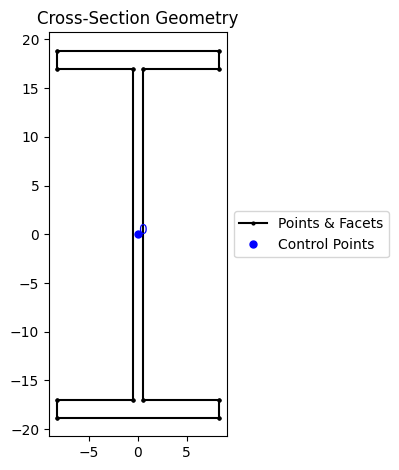

torsional constant = 76.38036877558419


In [33]:
from sectionproperties.pre.geometry import Geometry

bf = 16.6
tw = 1.02
tf = 1.85
d = 37.7

y_offset = 0
z_offset = 0

points = [
    [-bf / 2, -d / 2],
    [bf / 2, -d / 2],
    [bf / 2, -d / 2 + tf],
    [tw / 2, -d / 2 + tf],
    [tw / 2, d / 2 - tf],
    [bf / 2, d / 2 - tf],
    [bf / 2, d / 2],
    [-bf / 2, d / 2],
    [-bf / 2, d / 2 - tf],
    [-tw / 2, d / 2 - tf],
    [-tw / 2, -d / 2 + tf],
    [-bf / 2, -d / 2 + tf],
]

for p in points:
    p[0] += y_offset
    p[1] += z_offset

facets = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 8],
    [8, 9],
    [9, 10],
    [10, 11],
    [11, 0],
]

holes = []
control_points = [[y_offset, z_offset]]
geometry = Geometry.from_points(points, facets, control_points)

geometry.create_mesh(mesh_sizes=.2)
geometry.plot_geometry()

cells = to_cell3dos(geometry, no_warping=False)

to_file(cells, "w36x330.sp")

print(f'torsional constant = {sum(f.area * ((f.pz + f.y) * f.y - (f.py - f.z) * f.z) for f in cells)}')

### Validation

We use the following script to validate the result.

```text
node 1 0 0 0
node 2 1 0 0
node 3 0 0 0
node 4 1 0 0
node 5 0 0 0
node 6 1 0 0
material ElasticOS 1 2 0
file w36x330.sp
orientation B3DOSL 1 0. 0. 1.
element B31OS 1 1 2 743 1 6
element B31OS 2 3 4 743 1 6
element B31OS 3 5 6 743 1 6
fix2 1 E 1 3 5
displacement 1 0 1E-2 4 2 ! torsion
displacement 2 0 1E-2 5 4 ! bending
displacement 3 0 1E-2 6 6 ! bending
hdf5recorder 1 Node RF 2
step static 1
set ini_step_size 1E-2
set fixed_step_size true
converger RelIncreDisp 1 1E-10 20 1
analyze
peek node 2 4 6
save recorder 1
exit
```

The nodal displacement and force are as follows.

```text
Node 2:
Coordinate:
  1.0000e+00  0.0000e+00  0.0000e+00
Displacement:
 -1.2749e-02 -2.5176e-08  5.7405e-10  1.0000e-02 -1.2320e-09 -5.0350e-08  1.0000e-02
Resistance:
  7.6473e-16 -1.0666e-16 -5.8801e-15  2.4018e+00 -1.9441e-15  1.9292e-16 -2.3900e-12

Node 4:
Coordinate:
  1.0000e+00  0.0000e+00  0.0000e+00
Displacement:
 -4.1507e-06 -9.0941e-08 -5.0000e-03 -6.6684e-07  1.0000e-02 -1.9895e-07 -6.8420e-07
Resistance:
 -1.9119e-15  4.5061e-16 -5.1159e-13 -8.1603e-14  4.6183e+02 -8.2257e-16 -8.9705e-14

Node 6:
Coordinate:
  1.0000e+00  0.0000e+00  0.0000e+00
Displacement:
 -4.1652e-06  5.0000e-03  4.5272e-09  1.7407e-09 -9.0517e-09  1.0000e-02  3.9205e-10
Resistance:
  3.1130e-16  3.9080e-14 -1.3846e-14 -3.2508e-14 -6.3221e-15  2.8240e+01 -1.9785e-14
```

We can obtain two moments of inertia as follows.

$$
I_z=4.6183\times10^4/2=23092,\qquad
I_y=2.8240\times10^3/2=1412.
$$

The AISC table gives $$23300$$ and $$1420$$, respectively.

Furthermore, one can plot the torque-rotation curve.

[[0.         0.        ]
 [0.1        0.07493164]
 [0.2        0.15987849]
 [0.3        0.2648558 ]
 [0.4        0.39987876]
 [0.5        0.57496262]
 [0.6        0.80012258]
 [0.7        1.08537387]
 [0.8        1.44073171]
 [0.9        1.87621132]
 [1.         2.40182793]]


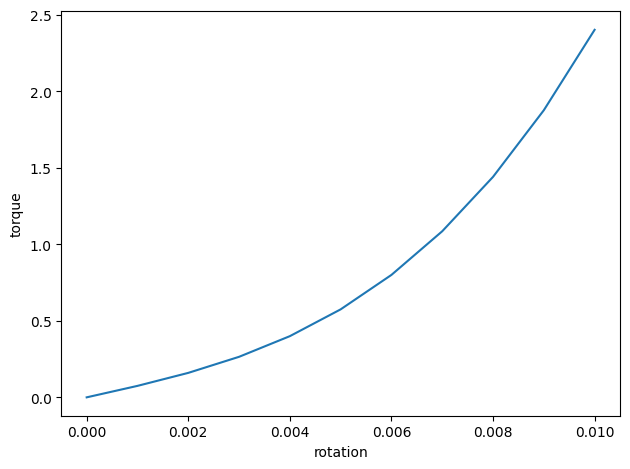

In [34]:
import h5py

with h5py.File("R1-RF.h5", "r") as f:
    data = f["/R1-RF/R1-RF2"]
    print(data[:, [0, 4]])
    plt.plot(data[:, 0] * 1E-2, data[:, 4])
    plt.xlabel("rotation")
    plt.ylabel("torque")
    plt.tight_layout()
    plt.show()

We shall see the initial stiffness is $$74.93$$, which is close to the torsional constant $$J$$.
Due to the existence of bi-moments, the torque is not linearly proportional to the rotation.
If one records the `BEAMS` output, the St. Venant torsion would be $$GJ\phi'$$.

## Flat Bar Example

We show another example with analytical solution.
This example is taken from this [paper](https://doi.org/10.1061/(ASCE)0733-9445(2005)131:7(1135)).

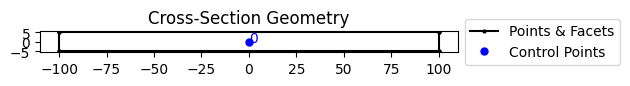

In [35]:
b = 200
d = 10

points = [
    [-b / 2, -d / 2],
    [b / 2, -d / 2],
    [b / 2, d / 2],
    [-b / 2, d / 2],
]

facets = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0]
]

holes = []
control_points = [[0, 0]]
geometry = Geometry.from_points(points, facets, control_points)
geometry.create_mesh(mesh_sizes=[2])
geometry.plot_geometry()
to_file(to_cell3dos(geometry), "flat.sp")

Use the following model to apply an end twist.

```text
# flat bar
node 1 0 0 0
node 2 1000 0 0
material ElasticOS 1 200 .25
file flat.sp
orientation B3DOSL 1 0. 0. 1.
element B31OS 1 1 2 1574 1 6
fix2 1 E 1
displacement 1 0 1.4 4 2
hdf5recorder 1 Node RF4 2
step static 1
set ini_step_size 1E-2
set fixed_step_size true
converger RelIncreDisp 1 1E-10 5 1
analyze
save recorder 1
exit
```

Use the following script to plot the results.

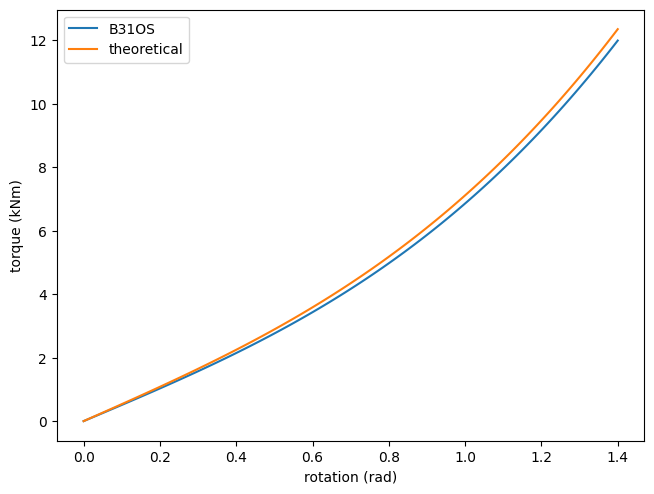

In [36]:
with h5py.File('R1-RF4.h5', 'r') as f:
    data = f['/R1-RF4/R1-RF42']
    x = data[:, 0] * 1.4
    plt.plot(x, data[:, 1] / 1000, label='B31OS')
    ref = [z * .080 * 66.667 + .100 * 17.778 * z ** 3 for z in x]
    plt.plot(x, ref, label='theoretical')
    plt.legend()
    plt.xlabel('rotation (rad)')
    plt.ylabel('torque (kNm)')
    plt.tight_layout(pad=.2)
    plt.show()

The discretisation introduces some errors. With mesh refinement, the numerical result approaches the analytical solution.

## Closing Remarks

1. `Cell3DOS` is the basic building block. `Fibre3DOS` collects all cells and defines the section. `B31OS` is the corresponding element.
2. Sectional integration is always about the origin of the local coordinate system. Shifting of axis can be accounted for by directly defining the section in the shifted position.